## Random policy performance evaluation on the Inverted-pendulum problem

- source code of the environment can be found [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML

import gym
from gym import wrappers
import custom_cartpole  # custom cart-pole environment

import io
import base64
import itertools
import tqdm

from scipy.stats import rankdata as rd
from scipy import stats

In [2]:
########################################
########## custom environment ##########

# # maximum length of a trajectory set to 1500 steps
# gym.envs.register(id='CartPole_PbPI_Version-v0'
#                   , entry_point='gym.envs.classic_control:CartPoleEnv'
#                   , max_episode_steps=1500)


########## helper functions ##########

# generate a random action from a given environment
def random_action(environment, seed=10):
    """ return a random action from the given environment. """
    
    # set env. seeds for reproducibility
    #environment.action_space.np_random.seed(seed) 
    #environment.seed(seed) 
    
    return environment.action_space.sample()


# generate a list of initial states from a given environment
def generate_init_states_S(seed
                           , env = 'CustomCartPole-v0'):
    """ this function returns a list of randomly generated initial states from a given environment. """
    
    # set the random seed for reproducibility
    np.random.seed(seed)
    
    # define how many states to generate
    n_states = np.random.randint(low=1, high=101) 

    # define a list to store the generated initial states
    init_states_S = []

    # create a given environment object
    env = gym.make(env)
    env.action_space.np_random.seed(seed) # set env. seeds for reproducibility
    env.seed(seed) # set env. seeds for reproducibility
    env.reset()

    # create initial states
    for _ in range(n_states):

        # step through the environment
        state, reward, done, info = env.step(env.action_space.sample())  
            
        # if terminates, reset the environment
        # and continue to next step (without appending to state list)
        # increment 'n_states' count by 1
        if done: 
            env.reset()
            n_states+=1
            
        # append the geneareted state to list
        # there are observations with different shape: this step skips them
        if len(state.shape)>1:
            init_states_S.append(state)
      
    env.close()
            
    return init_states_S[:]


# partition the action space of a given environment 
def partition_action_space(env_name:'string'
                           , n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)

    # partition the action space to a given number of actions
    # - a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(env.action_space.low[0,0]
                                 ,env.action_space.high[0,0],n_actions) + np.random.uniform(low = -.2,high=.2)
    
    return part_act_space  


########################################

### Generate evaluations for Random Policy

In [6]:
def run_evaluations_random(state_list         # list of initial states
                            , step_thresh = 100    # step-count (threshold)
                            , env_name ='CustomCartPole-v0' # name of the environment
                            , simulations_per_state = 100 # number of simulations to generate per state
                           ):  
    
    """
    Description:
    
        - For every state in a given list of initial states, 100 simulations are generate and the percentage of
           these simulations that exceeds a predefined step-count threadhold (trajectory length) is computed to measure 
           the performance of the random policy."""
    

    simu_per_state = simulations_per_state
        
    # create an environment instance
    env_test = gym.make(env_name)
    
    # variable to record the sufficient policy count (across all simulations)
    suf_policy_count = 0
    
    # iterate over all states in the state list
    for state in state_list:        
        
        # generate 100 simulations from each state
        for _ in range(simu_per_state):
            
            # set the starting state and the current observation to the given state 
            env_test.reset(init_state= state)
        
            # variable to store the return of an episode
            return_ep = 0 

            # execute 1001 steps in the environment
            for _ in range(1001):
                action = env_test.action_space.sample() # generate action from the policy
                observation, reward, done, info = env_test.step(action) # execute action
                return_ep += reward   # compute return
                if done: break

            env_test.reset()
            env_test.close()

            # increment the sufficient policy count if return exceeds given threshold
            # (note: at every step, 1 reward is produced in the environment)
            if return_ep>=step_thresh:
                suf_policy_count += 1
                
    # return the aggregated sufficient policy count from the policy evaluation
    return (suf_policy_count/(len(state_list)*simu_per_state))


Number of initial states: 45


Number of actions (per states): 3



Iteration:  13%|█████████▌                                                              | 4/30 [00:59<06:25, 14.81s/it]

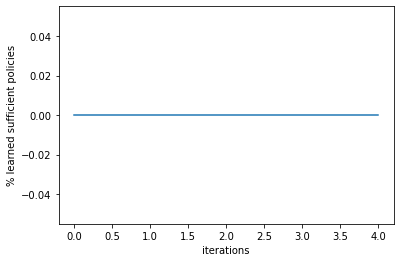

Iteration:  30%|█████████████████████▌                                                  | 9/30 [02:20<05:43, 16.36s/it]

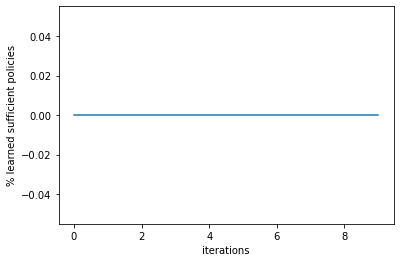

Iteration:  47%|█████████████████████████████████▏                                     | 14/30 [03:44<04:28, 16.79s/it]

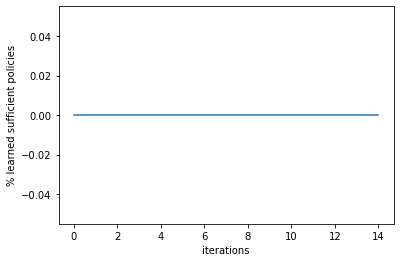

Iteration:  63%|████████████████████████████████████████████▉                          | 19/30 [04:58<02:47, 15.23s/it]

In [ ]:
# initialize environment
env = gym.make('CustomCartPole-v0')

# sample states
seed = 4
sample_states = generate_init_states_S(seed) # randomly generated states initial

print(f'\nNumber of initial states: {len(sample_states)}\n')

# maximum number of policy iterations
max_iterr = 30

# action space to consider
act_space = partition_action_space('CustomCartPole-v0',3)
print(f'\nNumber of actions (per states): {len(act_space)}\n')

# generate action-pairs (per each)
act_pairs = list(itertools.combinations(act_space,2))

# initial random policy
policy_init = random_action
policy = policy_init

# store evaluation results (% of learned sufficient policies)
agg_pct_l_policies = []

# algorithm iteration loop progress
pbar = tqdm.tqdm(total=max_iterr, desc="Iteration", position = 0)

iterr = 1
while iterr < max_iterr:
    
    policy = random_action
    
    # compute the average return over all roll-outs starting at init. states by new policy
    pct_succ_policies = run_evaluations_random(state_list = sample_states
                                                , step_thresh=150)
    agg_pct_l_policies.append(pct_succ_policies)
    
    if iterr%5 == 0:
        # clear the last plot data
        plt.clf()
        plt.cla()
        plt.close()

        # plotting rewards over iterations
        plt.plot(range(iterr), agg_pct_l_policies)
        plt.ylabel('% learned sufficient policies')
        plt.xlabel('iterations')
        plt.savefig(f'./train_imgs/random_policy.png') # save the evaluation image
        plt.show()
        
    # update the algorithm iteration loop status
    pbar.update(1)
    iterr += 1
        
pbar.close()